# Datasets and Dataloaders

## Dataset
- Acts as a **container** for raw data.
- Provides access to **individual samples** via indexing (`dataset[idx]`).
- Implements:
  - `__len__`: Returns the size of the dataset.
  - `__getitem__`: Fetches a single sample by index.
- Does **not handle batching**, shuffling, or parallel loading.

## Dataloader
- Wraps a `Dataset` and acts as an **iterator** for easy data loading.
- Provides **batches** of data for training or inference.
- Handles:
  - **Batching**: Combines multiple samples into batches.
  - **Shuffling**: Randomizes the order of samples.
  - **Parallel loading**: Uses multiple worker threads or processes to load data.
- Implements:
  - `__iter__`: Returns an iterator that fetches batches.
 
## Summary
| Feature              | `Dataset`                | `DataLoader`            |
|-----------------------|--------------------------|--------------------------|
| **Role**             | Data container           | Iterator for data loading |
| **Access**           | Single sample            | Batches of samples       |
| **Indexing**         | Yes (`dataset[idx]`)     | No                       |
| **Batching**         | No                       | Yes                      |
| **Shuffling**        | No                       | Yes                      |
| **Parallel Loading** | No                       | Yes                      |

## Example of a Very Simple Dataset and Dataloader

In [1]:
import time

import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
class SimpleDataset(Dataset):
    
    def __init__(self):
        # Create some dummy data (e.g., n samples of 2D points)
        self.inputs = torch.arange(10).view(-1, 2)  # samples of [x, y] pairs
        self.targets = torch.arange(5) 
        
    def __len__(self):
        # Number of samples in the dataset
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx], self.targets[idx]

dataset = SimpleDataset()

In [3]:
batch_size = 2
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
for batch_idx, (inputs, target) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs: {inputs.numpy()}")
    print(f"Target: {target.numpy()}")
    print()

Batch 1
Inputs: [[0 1]
 [2 3]]
Target: [0 1]

Batch 2
Inputs: [[4 5]
 [6 7]]
Target: [2 3]

Batch 3
Inputs: [[8 9]]
Target: [4]



## More complex example 

### Fake data creation

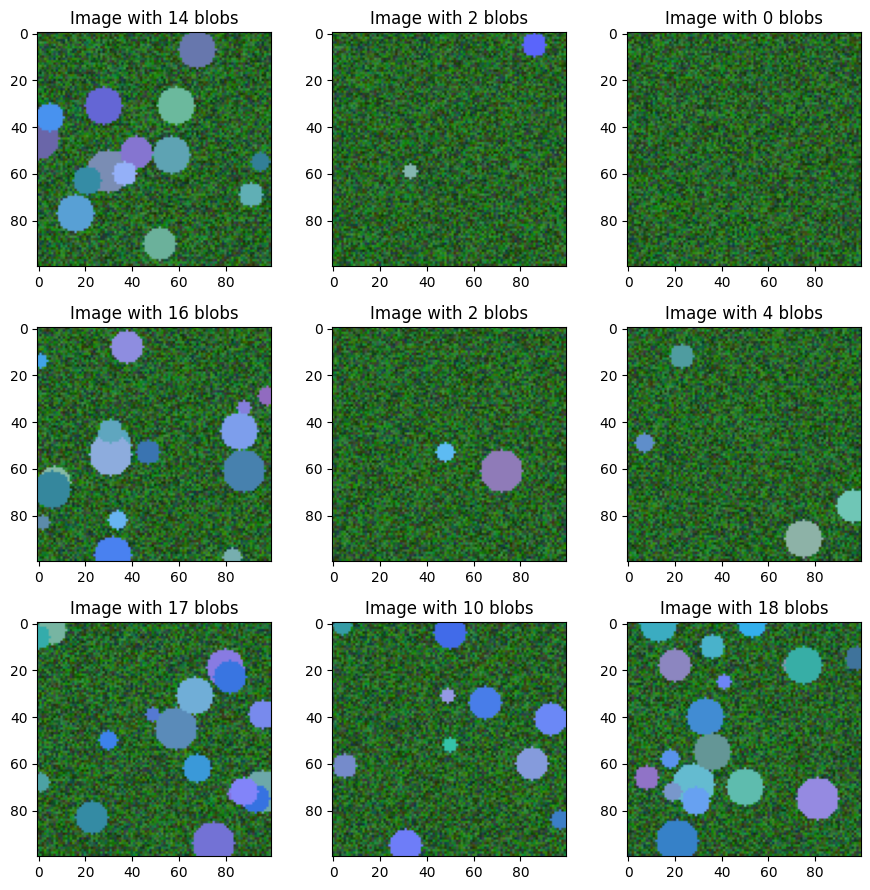

In [4]:
def generate_image_with_label():
    size = 100
    max_count = 20
    # genearate noisy background
    start = np.array([10, 50, 0], dtype="uint8")
    stop = np.array([70, 150, 80], dtype="uint8")
    img = np.random.rand(size, size, 3)  # Random floats in [0, 1)
    img = (img * (stop - start) + start).astype("uint8")
    # generate patches
    number = np.random.randint(0, max_count)
    centers = np.random.randint(0, size, (number, 2))
    radii = np.random.randint(3, 10, number)
    colors = np.random.randint((50, 100, 150), (150, 200, 255), (number, 3), dtype="int")
    for center, radius, color in zip(centers, radii, colors):
        cv.circle(img, center, radius, list(map(int, color)), -1)
    return img, number

plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, i * cols + j + 1)
        img, label = generate_image_with_label()
        plt.imshow(img)
        plt.title(f"Image with {label} blobs")
plt.tight_layout()
plt.show()

### Dataset Creation and Inspection

In [5]:
class BlobDataset(Dataset):
    
    def __init__(self, data, labels):
        self._transform = transforms.Compose([
            transforms.ToTensor(),  # Convert the image to a tensor with values [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
        ])
        self.inputs = [self._transform(img) for img in data]
        self.targets = [torch.tensor(y).float() for y in labels]

    def __len__(self):
        # Number of samples in the dataset
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx], self.targets[idx]


In [6]:
np.random.seed(101)
data_count = 300
data_all, labels_all = zip(*[generate_image_with_label() for idx in range(data_count)])
data_train, data_val, labels_train, labels_val = train_test_split(data_all, labels_all, test_size=0.2, random_state=101)

train_dataset = BlobDataset(data_train, labels_train)
val_dataset = BlobDataset(data_val, labels_val)

### Dataloader Creation and Inspection

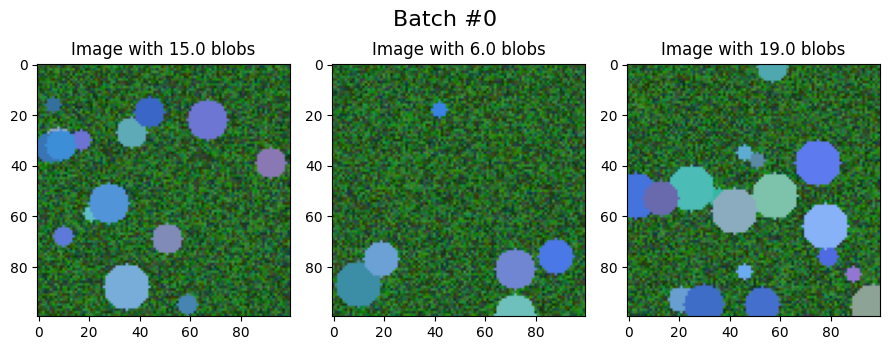

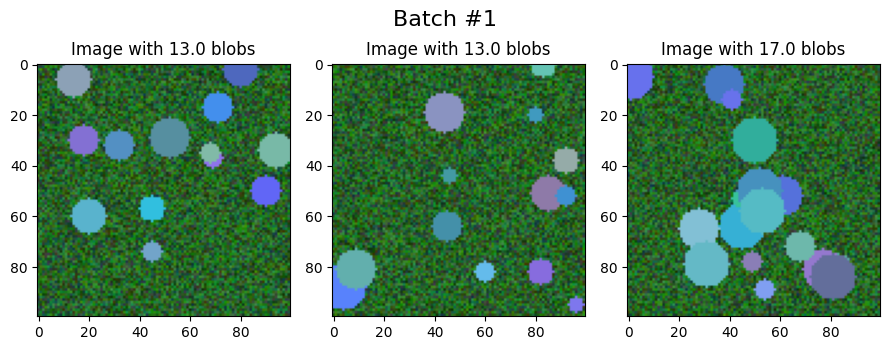

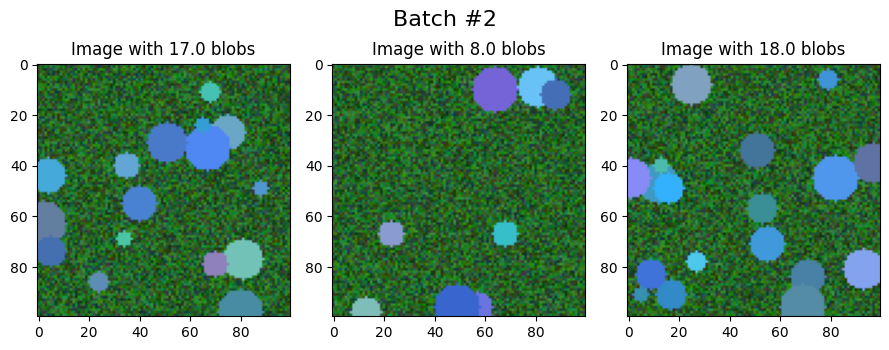

In [7]:
def reverse_transform(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Denormalize
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # t = t * s + m
    # Convert back to HWC and scale to [0, 255]
    img = tensor.permute(1, 2, 0).cpu().numpy()  # CHW to HWC
    img = (img * 255).clip(0, 255).astype('uint8')  # Scale and convert to uint8
    return img

batch_size = 3
shuffle = False
dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
for batch_idx, (inputs, targets) in enumerate(dataloader):
    if batch_idx < 3:
        fig = plt.figure(figsize=(9, 9))
        fig.text(0.5, 0.7, f"Batch #{batch_idx}", ha='center', va='top', fontsize=16)
        for idx in range(batch_size):
            plt.subplot(1, batch_size, idx + 1)
            image = reverse_transform(inputs[idx])
            plt.imshow(image)
            plt.title(f"Image with {targets[idx]} blobs")
        plt.tight_layout()
        plt.show()     

### Expected model error

In [8]:
experiments_number = 100
targets = np.array([val_dataset.targets], dtype="int").squeeze()
MAEs = np.zeros(experiments_number)
for k in range(experiments_number):
    random_guess = np.random.randint(targets.min(), targets.max(), len(targets))
    MAEs[k] = np.abs(targets - random_guess).mean()

f"Average results of random guessing ({experiments_number} trials) is {MAEs.mean()} patches per image"

'Average results of random guessing (100 trials) is 6.4675 patches per image'

## Model and Training with Dataloader

### Model Design

In [9]:
class BlobCounterV1(nn.Module):
    def __init__(self):
        super(BlobCounterV1, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 64 input channels, 128 output channels
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # 128 input channels, 256 output channels
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)  # Average pooling layer to reduce spatial dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 2048)  # Flattened output after convolution and pooling (256 channels, 6x6 spatial size)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 1)  # Regression output for counting patches
        
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        # Apply convolution and pooling layers
        x = self.relu(self.conv1(x))  # First convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv2(x))  # Second convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv3(x))  # Third convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv4(x))  # Fourth convolutional layer
        x = self.pool(x)  # Pooling layer

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # Flatten (batch_size, 256 * 12 * 12)        

        # Pass through the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # Output layer
        
        return x.squeeze(-1)  # Return scalar value as the count of patches

Epoch [0/30], Time: 2.53s, Training Loss: 252.41989,  Validation Loss: 68.85023, "MAE: 6.700
Epoch [1/30], Time: 2.54s, Training Loss: 662.75385,  Validation Loss: 43.86623, "MAE: 5.520
Epoch [2/30], Time: 2.44s, Training Loss: 136.74272,  Validation Loss: 130.48761, "MAE: 9.899
Epoch [3/30], Time: 2.44s, Training Loss: 243.28922,  Validation Loss: 139.49094, "MAE: 10.335
Epoch [4/30], Time: 2.44s, Training Loss: 254.53799,  Validation Loss: 140.37450, "MAE: 10.377
Epoch [5/30], Time: 2.67s, Training Loss: 255.27586,  Validation Loss: 140.30609, "MAE: 10.374
Epoch [6/30], Time: 2.50s, Training Loss: 255.74442,  Validation Loss: 140.04208, "MAE: 10.361
Epoch [7/30], Time: 2.53s, Training Loss: 254.50671,  Validation Loss: 139.58015, "MAE: 10.340
Epoch [8/30], Time: 2.45s, Training Loss: 252.92737,  Validation Loss: 138.50191, "MAE: 10.289
Epoch [9/30], Time: 2.51s, Training Loss: 252.25528,  Validation Loss: 135.96416, "MAE: 10.169
Epoch [10/30], Time: 2.43s, Training Loss: 244.65411,  

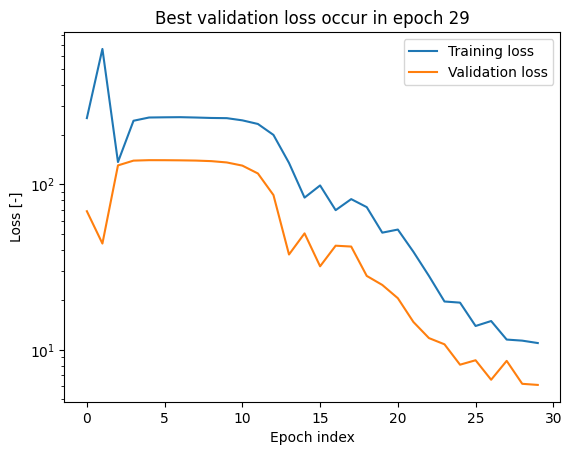

In [10]:
epochs = 30
batch_size = 128

model = BlobCounterV1()

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.AdamW(model.parameters(), lr=0.001)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    t0 = time.time()
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.numpy() - val_outputs.detach().numpy()))
    mae = np.concatenate(errors).mean()

    elapsed_time = time.time() - t0
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{epochs}], Time: {elapsed_time:.2f}s, Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()

### Fake Dataset (Infinite Number of Samples)

Example improvements:
- We generate new images on-the-fly so the model cannot overtrain
- We decrease the learning rate in time
- Move training to GPU

In [11]:
class FakeBlobDataset(Dataset):
    
    def __init__(self, number, device="cpu"):
        self._transform = transforms.Compose([
            transforms.ToTensor(), # Convert the image to a tensor with values [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
        ])
        self._number = number
        self._device = device
    
    def __len__(self):
        return self._number
    
    def __getitem__(self, idx):
        img, label = generate_image_with_label()
        img = self._transform(img).to(self._device)
        label = torch.tensor(label).float().to(self._device)
        return img, label



Epoch [0/100], Time: 1.90s, Training Loss: 306.68958,  Validation Loss: 344.05295, "MAE: 17.433
Epoch [20/100], Time: 0.52s, Training Loss: 16.08287,  Validation Loss: 6.72214, "MAE: 2.020
Epoch [40/100], Time: 0.54s, Training Loss: 12.92503,  Validation Loss: 4.31537, "MAE: 1.604
Epoch [60/100], Time: 0.59s, Training Loss: 11.88125,  Validation Loss: 3.13725, "MAE: 1.234
Epoch [80/100], Time: 0.60s, Training Loss: 7.50323,  Validation Loss: 2.35766, "MAE: 1.121


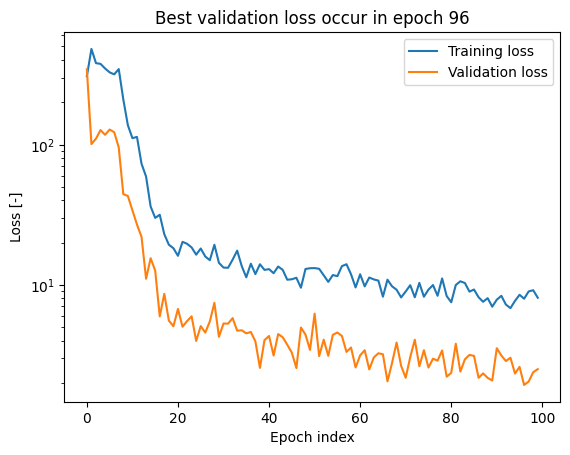

In [12]:
device = "cuda"
epochs = 100
batch_size = 128

fake_train_dataset = FakeBlobDataset(300, device=device)
fake_val_dataset = FakeBlobDataset(100, device=device)
model = BlobCounterV1().to(device)

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_dataloader = DataLoader(fake_train_dataset, batch_size=batch_size, shuffle=True) # here is the Fake dataset inserted
val_dataloader = DataLoader(fake_val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    t0 = time.time()
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
    scheduler.step()
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:       
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.to("cpu").numpy() - val_outputs.to("cpu").detach().numpy()))
    mae = np.concatenate(errors).mean()

    elapsed_time = time.time() - t0
    if epoch % 20 == 0:
        print(f'Epoch [{epoch}/{epochs}], Time: {elapsed_time:.2f}s, Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()